In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None 

import ast as ast
import numpy as np
from typing import *
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns


from task_2_helpers import *
from collections import Counter

# from task2_business_KNN import classify_Kmeans


### Data Read

In [6]:
df_data_res = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')
print(df_data_res.shape)
print(df_data_res.columns)
df_data_res.head(5)


(123414, 15)
Index(['business_id', 'postal_code_int', 'attributes_list', 'hours_list',
       'categories_list', 'latitude', 'longitude', 'id', 'user_id', 'rating',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')


,business_id,postal_code_int,attributes_list,hours_list,categories_list,latitude,longitude,id,user_id,rating,useful,funny,cool,text,date
0,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,100621,Ax5a6F5AaOoPi-1MwOeuaM,4,1,0,2,So I don't know how the other review was doubl...,2017-08-24 04:23:03
1,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,174063,QZ7nC0AgxLr9B5E0IYguyf,5,0,0,0,I love this place.. I love their chunky fried...,2020-05-25 16:27:36
2,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,234948,gnTp6PHiW40FPYsSwXt37u,5,0,0,1,I ordered so many cake from here for our famil...,2019-07-25 13:09:14
3,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,285755,wKRfxlkzQXfEsHSDYhPVVq,4,0,0,0,Ordered a birthday cake here for the first tim...,2019-03-12 17:04:09
4,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,330446,QikAd9bkgEVafOR5e5EeqW,5,1,0,0,This is my favorite bakery in Chinatown! It's ...,2017-09-13 00:38:08


### 2.2 Food Trends and Restaurant styles

We can analyse the food trends by two steps:

1 -  We have the category information of the restaurants and their rating. We can distribute these ratings among the categories and take an average per category. This approach gives us a generic liking of the certain categories. However, it doesn't show the trend. We also count the number of time a category appeared in the dataset. This shows the interest of the people to the certain style of restaurants. Using the average rating and the frequency we identify the most trendy restaurant categories. 

2 - From there we can identify the food trends. Most of the categories are related with the food style. We select the most trending 10 food style. We then calculate their corresponding rating by time and draw the evolution of the ratings by time


We apply the similar method to the attributes of the restaurants. We can find the most appreciated attributes and see their effect on the rating evolution by time.

In [8]:
data_cat_ratings =  df_data_res[['id','date','categories_list', 'rating']]
 
data_cat_rating_single = data_cat_ratings.explode('categories_list')

data_cat_rating_single['mean_rating'] = data_cat_rating_single[['categories_list', 'rating']]\
                        .groupby('categories_list')['rating'].transform('mean')

data_cat_rating_single['frequency'] = data_cat_rating_single['categories_list'].map(data_cat_rating_single['categories_list'].value_counts())
data_cat_rating_single['rating_freq_ratio'] = data_cat_rating_single['frequency']/len(data_cat_ratings)

data_cat = data_cat_rating_single[['categories_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'categories_list':'categories'}) #.set_index('date')


data_cat = data_cat[(data_cat['rating_freq_ratio'] > 0.05) ]

data_cat.sort_values(by='mean_rating', ascending=False, inplace=True)
data_cat.head(20)

,categories,frequency,mean_rating,rating_freq_ratio
176519,specialty food,7207,4.072430,0.058397
176363,cafes,7019,4.055706,0.056874
176005,vegetarian,6366,4.024505,0.051582
176160,desserts,6404,4.011555,0.051890
175591,beer,6226,4.008834,0.050448
175591,wine & spirits,6226,4.008834,0.050448
176522,coffee & tea,11148,3.974435,0.090330
175692,japanese,6805,3.907127,0.055140
176522,food,37842,3.888642,0.306626
174802,asian fusion,6733,3.877469,0.054556


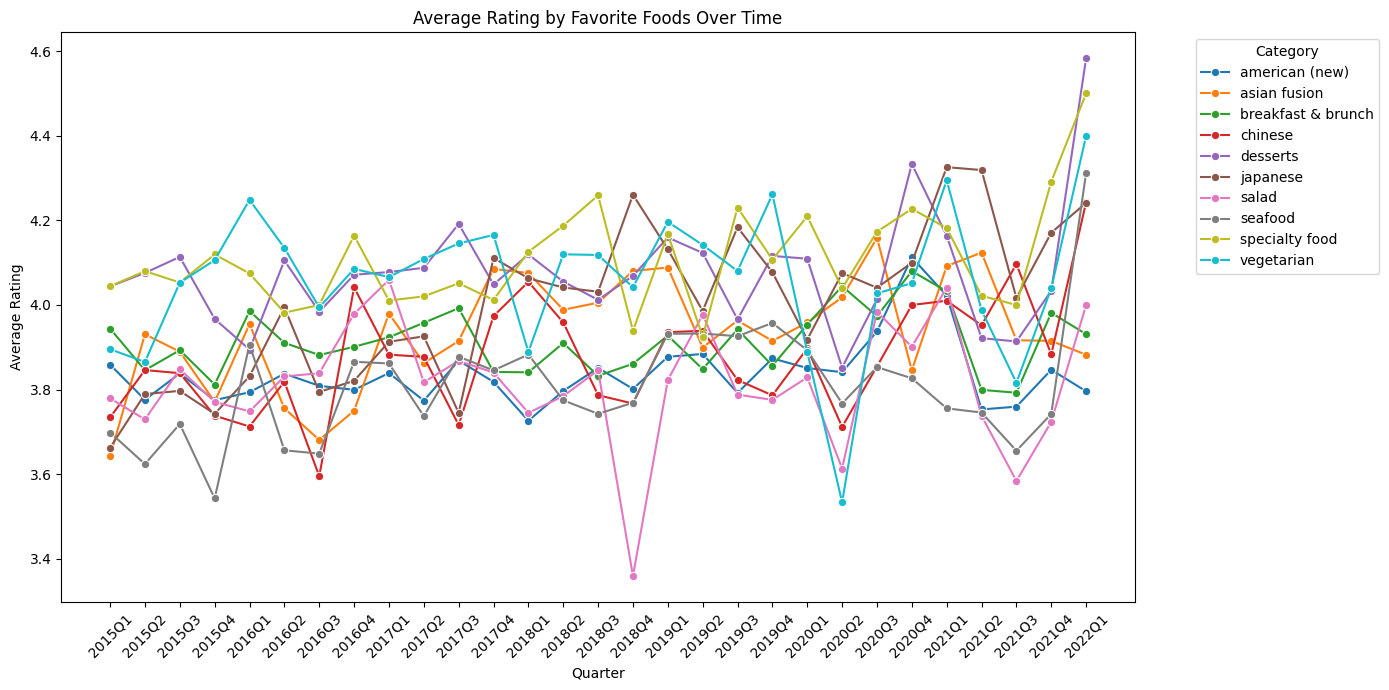

In [13]:
chosen_cat=['specialty food', 'vegetarian', 'desserts', 'japanese', 'asian fusion', 'breakfast & brunch', 'chinese', 'salad', 'seafood', 'american (new)']

data_cat_rating_chosen = data_cat_rating_single.loc[data_cat_rating_single.categories_list.isin(chosen_cat), ['date','rating', 'categories_list']]\
                            .rename(columns={'categories_list':'categories'})

data_cat_rating_chosen['date'] = pd.to_datetime(data_cat_rating_chosen['date'])

data_cat_rating_chosen = data_cat_rating_chosen[data_cat_rating_chosen['date'] > '2015-01-01']
data_cat_rating_chosen['quarter'] = data_cat_rating_chosen['date'].dt.to_period('Q').astype(str)

df_grouped = data_cat_rating_chosen.groupby(['quarter', 'categories']).rating.mean().reset_index()

df_pivot = df_grouped.pivot(index='quarter', columns='categories', values='rating')
df_pivot = df_pivot.sort_index()


# Plot the data
plt.figure(figsize=(14, 7))

# Create a lineplot with seaborn
sns.lineplot(data=df_grouped, x='quarter', y='rating', hue='categories', marker='o')

# Adjust the legend to be on the side
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set plot labels and title
plt.xlabel('Quarter')
plt.ylabel('Average Rating')
plt.title('Average Rating by Favorite Foods Over Time')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


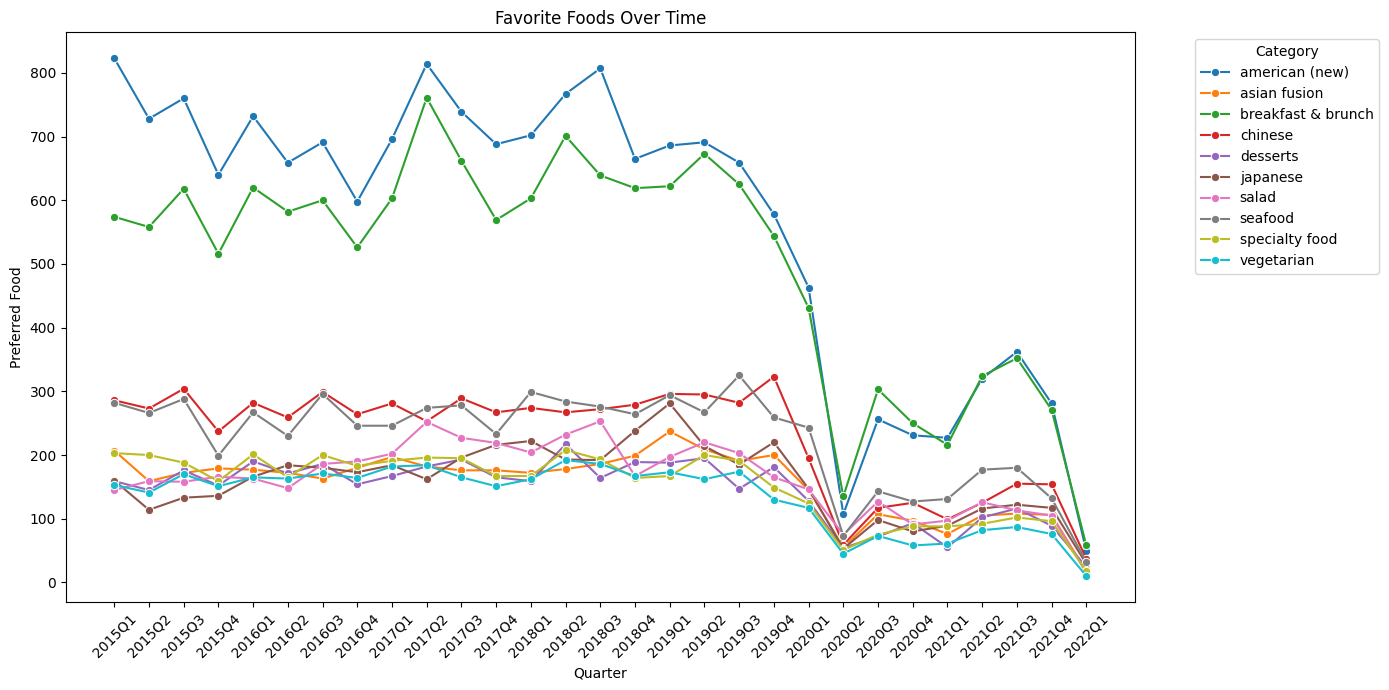

In [14]:
chosen_cat=['specialty food', 'vegetarian', 'desserts', 'japanese', 'asian fusion', 'breakfast & brunch', 'chinese', 'salad', 'seafood', 'american (new)']

data_cat_rating_chosen = data_cat_rating_single.loc[data_cat_rating_single.categories_list.isin(chosen_cat), ['date','rating', 'categories_list']]\
                            .rename(columns={'categories_list':'categories'})

data_cat_rating_chosen['date'] = pd.to_datetime(data_cat_rating_chosen['date'])

data_cat_rating_chosen = data_cat_rating_chosen[data_cat_rating_chosen['date'] > '2015-01-01']
data_cat_rating_chosen['quarter'] = data_cat_rating_chosen['date'].dt.to_period('Q').astype(str)

df_grouped = data_cat_rating_chosen.groupby(['quarter', 'categories']).size().reset_index(name='frequency')


# Plot the data
plt.figure(figsize=(14, 7))

# Create a lineplot with seaborn
sns.lineplot(data=df_grouped, x='quarter', y='frequency', hue='categories', marker='o')

# Adjust the legend to be on the side
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set plot labels and title
plt.xlabel('Quarter')
plt.ylabel('Preferred Food')
plt.title('Favorite Foods Over Time')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


#### 2.3 Suggestions for the restaurants

In [8]:
data_att_ratings =  df_data_res[['id','date','attributes_list', 'rating']]
 
data_att_rating_single = data_att_ratings.explode('attributes_list')
data_att_rating_single['attributes_mean_rating'] = data_att_rating_single[['attributes_list', 'rating']].groupby('attributes_list')['rating'].transform('mean')

data_att = data_att_rating_single[['date', 'attributes_list', 'attributes_mean_rating']]\
            .drop_duplicates(keep='last').rename(columns={'attributes_list':'attributes', 'attributes_mean_rating':'mean_rating'}) #.set_index('date')

data_att.head()

,date,attributes,mean_rating
0,2017-08-24 04:23:03,alcohol,3.785099
0,2017-08-24 04:23:03,bikeparking,3.804002
0,2017-08-24 04:23:03,businessacceptscreditcards,3.781729
0,2017-08-24 04:23:03,businessparking-street,3.867158
0,2017-08-24 04:23:03,byappointmentonly,4.029273
